<a href="https://colab.research.google.com/github/Adeeshdiwan/Coderguy/blob/master/Route_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install osmnx
!pip install ortools


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2


ImportError: cannot import name 'TopologicalError' from 'shapely.geos' (/usr/local/lib/python3.12/dist-packages/shapely/geos.py)

In [ ]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

In [28]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [29]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

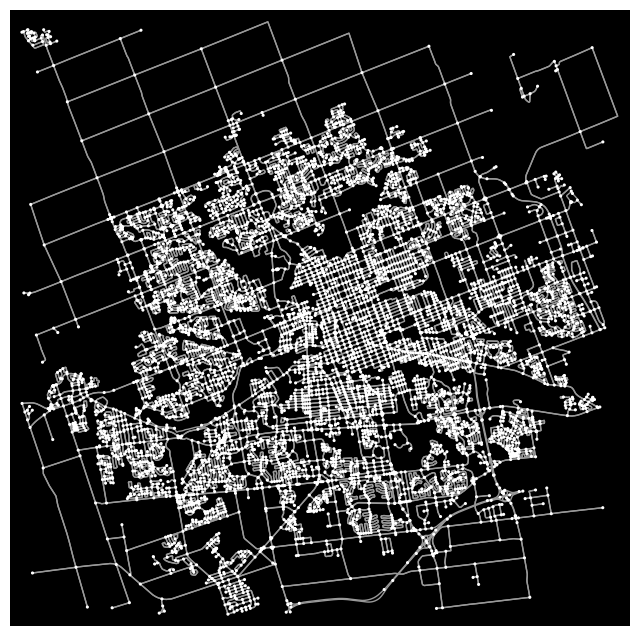

In [30]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [31]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

/tmp/ipython-input-2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
/tmp/ipython-input-2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
/tmp/ipython-input-2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [32]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,313714330,2600781784,1556562903,4703680516,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.000000,563.759970,353.942563,594.678143,498.839821,403.698038,127.139026,402.391671,554.860555,102.012149,514.358046,435.770658,233.642598,199.927550,568.038555,227.542287,524.772480,477.177999,1034.763832,1034.933448
324811692,590.690912,0.000000,210.859304,1099.717182,951.903938,711.487978,458.185901,880.622802,736.674378,490.253509,377.117754,891.320475,670.808777,403.323786,679.652060,780.276919,119.622776,982.217038,1309.429186,783.876391
11756886360,379.831608,209.817407,0.000000,913.336782,741.044634,580.321240,247.326597,669.763498,550.293978,279.394205,395.633221,704.940074,459.949473,192.464482,588.829897,581.607063,240.566976,795.836637,1203.551895,916.208622
252974916,593.056428,1096.700937,915.165915,0.000000,429.126451,858.806041,705.334621,332.678302,479.145005,667.039747,726.691348,353.839753,502.173115,766.253394,1084.937153,433.212891,1027.240027,175.002211,1230.599777,978.436231
302754873,498.771341,952.177966,742.360559,430.114182,0.000000,481.015808,573.308534,116.491253,892.396439,513.828819,865.947728,765.415286,348.962187,568.599984,707.146920,395.295350,982.927535,312.614038,852.809544,1391.687666


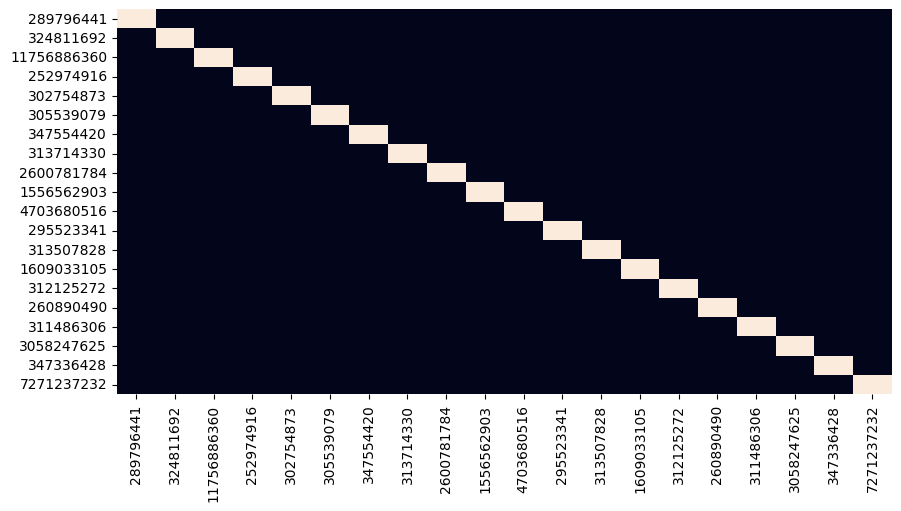

In [33]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [34]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,313714330,2600781784,1556562903,4703680516,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,564,354,595,499,404,127,402,555,102,514,436,234,200,568,228,525,477,1035,1035
324811692,591,0,211,1100,952,711,458,881,737,490,377,891,671,403,680,780,120,982,1309,784
11756886360,380,210,0,913,741,580,247,670,550,279,396,705,460,192,589,582,241,796,1204,916
252974916,593,1097,915,0,429,859,705,333,479,667,727,354,502,766,1085,433,1027,175,1231,978
302754873,499,952,742,430,0,481,573,116,892,514,866,765,349,569,707,395,983,313,853,1392
305539079,404,643,584,862,485,0,436,548,895,376,868,768,414,410,310,559,748,744,688,1362
347554420,150,456,246,716,572,436,0,475,520,93,480,518,266,93,491,352,428,599,1067,1000
313714330,401,879,669,332,116,546,475,0,794,416,768,667,251,515,772,297,886,215,918,1294
2600781784,555,732,551,478,887,890,521,791,0,604,362,186,720,578,1002,564,663,633,1521,635
1556562903,170,489,279,668,512,376,93,416,604,0,563,538,206,125,493,337,504,551,1007,1084


In [35]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [36]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [37]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [39]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

Exception ignored in garbage collection:
Traceback (most recent call last):
  File "/tmp/ipython-input-2881824341.py", line 2, in get_distance
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexing.py", line 303, in iloc
    return _iLocIndexer("iloc", self)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
SystemError: <class 'pandas.core.indexing._iLocIndexer'> returned a result with an exception set
Exception ignored in garbage collection:
Traceback (most recent call last):
  File "/tmp/ipython-input-2881824341.py", line 2, in get_distance
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexing.py", line 303, in iloc
    return _iLocIndexer("iloc", self)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
SystemError: <class 'pandas.core.indexing._iLocIndexer'> returned a result with an exception set


route for driver:
[0, 18, 15, 19, 11, 8, 10, 16, 2, 13, 6, 9, 1, 14, 5, 12, 4, 7, 17, 3]
Total distance:8.18km
Nodes visited: 20


In [40]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347336428, 260890490, 7271237232, 295523341, 2600781784, 4703680516, 311486306, 11756886360, 1609033105, 347554420, 1556562903, 324811692, 312125272, 305539079, 313507828, 302754873, 313714330, 3058247625, 252974916]


In [1]:
!pip install osmnx==1.1.1

def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_route[i], lst_route[i+1] # changed lst_nodes to lst_route
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

# create map centered on the starting node
route_map = ox.plot_graph_folium(G, tiles='cartodbpositron', popup_attribute='name')

# plot each route on the map
for path in lst_paths:
    # added route_map=route_map and changed to ox.plot_graph_folium
    route_map = ox.plot_route_folium(G, path, route_map=route_map, route_color="blue", route_weight=2)

route_map

NameError: name 'lst_route' is not defined

In [ ]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df


In [ ]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [ ]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig

